## Project Description

To build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, the algorithm needs to automatically locate lung opacities on chest radiographs.

## Dataset

The dataset contains the following files and folders:
-	stage_2_train_labels.csv - The training set. It contains patientIds and bounding box / target information.
-	stage_2_detailed_class_info.csv – It provides detailed information about the type of positive or negative class for each image.

Apart from the above-mentioned data files (in csv format), the dataset also contains the images folders 
-	stage_2_train_images
-	stage_2_test_images
 
The images in the above-mentioned folders are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## Objective

The objective of this task is to Test the Model, Fine-Tunning and Repeat which will involve the following tasks to be done:
-	During our last task we were not able to train our model using the entire dataset. So, this time we will try to load the entire training set to train our model
-	Use different models to predict the cases of Pneumonia along with the region of lung opacities.

#### Import Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import os
import math
import cv2

from matplotlib import pyplot
import matplotlib.patches as patches

from skimage import measure
from skimage.transform import resize

import seaborn as sns
import pydicom as dcm

from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
import tensorflow as tf
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import Layer, Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model

#For MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

#For ResNet50
from tensorflow.keras.applications.resnet import ResNet50

#For tunning of model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

Setting up of Project Path

In [ ]:
data_dir = '../input/rsna-pneumonia-detection-challenge/'

train_images = data_dir + 'stage_2_train_images'

### Function Definitions

#### Function to load metadata from images

In [ ]:
class image_metadata():
    """
    Arguments:
        setName = name of the dataset
        file = filename
    """
    
    def __init__(self, setName, file):
        self.setName = setName
        self.file = file
    
    def __repr__(self):
        #a special method used to represent a class's objects as a string
        return self.imagePath()
    
    def imagePath(self):
        return os.path.join(self.setName, self.file)

In [ ]:
#function to load image metadata
def loadimagemetadata(dataSetName):
    """
    Arguments:
        dataSetName: path of the data set folder
    """
    
    imageMetadata = []
    for f in os.listdir(dataSetName):
        ext = os.path.splitext(f)[1]
        if ext == '.dcm':
            imageMetadata.append(image_metadata(dataSetName, f))
    return np.array(imageMetadata)

In [ ]:
#function to load image and patientId
def loadImage(path):
    """
    Arguments:
        path: path of the image
    """
    
    img = dcm.dcmread(path)
    return img

def getImgId(imgPath):
    """
    Arguments:
        imgPath: path of the image
    """
    
    return str(imgPath).split(".dcm")[0].split("/")[4]

Getting Metadata Information

In [ ]:
trainingSetImageMetadata = loadimagemetadata(train_images)
print('Shape of training set image metadata: ', trainingSetImageMetadata.shape)
print("Sample image path: ", trainingSetImageMetadata[0])

Shape of training set image metadata:  (26684,)
Sample image path:  ../input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm


Thus, the function loadimagedata has been used to load the images into the memory. After loading we have 26684 images in the "stage_2_train_images" folder which will act as a Training data for us. As we know these are images are in DICOM format which has pixel information as well as several tags added to it like PatientId, PatientAge, PatientGender etc.

Loading a sample Image

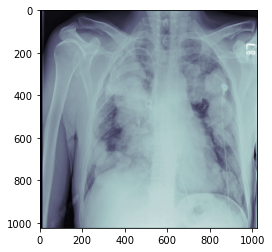

In [ ]:
imgIndex = 20
imgPath = trainingSetImageMetadata[imgIndex]
imgPath = imgPath.imagePath()
imgData = loadImage(imgPath)

pyplot.imshow(imgData.pixel_array, cmap = pyplot.cm.bone)

#### Preparing Dataset with patient Id and respective image paths

In [ ]:
trainSetImageMetadata_df = pd.DataFrame(trainingSetImageMetadata, columns = ['Path'])

imageIdpaths = pd.DataFrame(columns = ['patientId', 'imgPath'])
imageIdpaths['patientId'] = trainSetImageMetadata_df['Path'].apply(getImgId)
imageIdpaths['imgPath'] = trainSetImageMetadata_df['Path']

print("Shape of the concerned dataset: ", imageIdpaths.shape)
print('The dataset looks as:\n')
imageIdpaths.head()

Shape of the concerned dataset:  (26684, 2)
The dataset looks as:



,patientId,imgPath
0,c3b05294-29be-46e4-8a51-96fd211e4ca5,../input/rsna-pneumonia-detection-challenge/st...
1,6a6ed2c5-d179-4c19-aac7-0d70eb87e024,../input/rsna-pneumonia-detection-challenge/st...
2,06550cfd-e9d5-415e-bae9-3146329ed9e6,../input/rsna-pneumonia-detection-challenge/st...
3,ef9eee29-6bdd-41da-ae40-9473592a9d5c,../input/rsna-pneumonia-detection-challenge/st...
4,c5dfc1a7-4669-42ce-af9f-62c3d8322049,../input/rsna-pneumonia-detection-challenge/st...


Thus, we have a dataframe here with two columns: **patientId** and **imgPath**. These columns contains the patientid and the location where the images are stored.

## Reading CSV Files

After working with the images folder we will construct a dataframe using the two provided csv files "stage_2_detailed_class_info.csv" and "stage_2_train_labels.csv".

In [ ]:
detailclass_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
trainlabels_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [ ]:
print('The detailed class dataframe has {} rows and {} columns and looks like:'.format(detailclass_df.shape[0], detailclass_df.shape[1]))
detailclass_df.head()

The detailed class dataframe has 30227 rows and 2 columns and looks like:


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
print('The training label dataframe has {} rows and {} columns and looks like:'.format(trainlabels_df.shape[0], trainlabels_df.shape[1]))
trainlabels_df.head()

The training label dataframe has 30227 rows and 6 columns and looks like:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


From our visualization task we know the following things:
* We have a total of 30227 records (in both of the files) and out of that 26684 are unique records, thus some patients having multiple entries in the file
* There are two values in the "Target" column of the labels file: 0 suggesting No Pneumonia and 1 suggesting that the concerned patient does have Pneumonia
* There are 20672 entries in the labels file where bounding box cordinates are not available, thus these belongs to the Patients not having Pneumonia. There are 9555 entries where the coordinates are provided
* There are 3 Unique classes as observed from the class file: No Lung Opacity/Not Normal, Normal and Lung Opacity

In [ ]:
#sorting both the datasets based on patientId
trainlabels_df.sort_values('patientId', inplace = True)
detailclass_df.sort_values('patientId', inplace = True)

#concatenating the data
merge_data_df = pd.concat([trainlabels_df, detailclass_df['class']], axis = 1, sort = False)
print('The merged dataset has {} rows and {} columns and looks like:'.format(merge_data_df.shape[0], merge_data_df.shape[1]))
merge_data_df.head()

The merged dataset has 30227 rows and 7 columns and looks like:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


Both the dataframe has been merged to form a new dataset to have a much more detailed view. From this it is clear that Target with 0 corresponds either to "No Lung Opacity / Not Normal" or "Normal" and 1 with "Lung Opacity".

#### Prepare data for Training

We will convert the dataset to have just two classes for our ease of doing. Going forward **Target 0 will correspond to Normal class** whereas **Target 1 will corresponds with Lung Opacity**. 

In [ ]:
#convert the dataset into two classes only:
merge_data_df['class'].replace('No Lung Opacity / Not Normal', 'Normal', inplace = True)
print('The merge dataset now looks like:')
merge_data_df.head()

The merge dataset now looks like:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


#### Splitting of the dataset

We will split the merge_data_df to have three different datasets: train, validation and test.

In [ ]:
train_mergedata = merge_data_df[0:15000]
validate_mergedata = merge_data_df[15000:25000]
test_mergedata = merge_data_df[25000:30227]

print('Shape of training data: ', train_mergedata.shape)
print('Shape of validation data: ', validate_mergedata.shape)
print('Shape of test data: ', test_mergedata.shape)

Shape of training data:  (15000, 7)
Shape of validation data:  (10000, 7)
Shape of test data:  (5227, 7)


Thus we have a training set with 15000 entries, validation set with 10000 entries and 5227 with test dataset.

We will replace the NaN values present in the dataset with 0 for our convenience.

In [ ]:
#setting all NaN values to 0 in both the data sets
#x, y, width and hight values as zero(0) means no bounding box.
train_mergedata.fillna(0, inplace = True)
print('The training data now looks as: \n')
train_mergedata.head()

The training data now looks as: 



,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


In [ ]:
validate_mergedata.fillna(0, inplace = True)
print('\nThe validation data now looks as:\n')
validate_mergedata.head()


The validation data now looks as:



,patientId,x,y,width,height,Target,class
13841,8a546535-613f-49b1-897c-a0933c53cb84,97.0,157.0,228.0,583.0,1,Lung Opacity
13842,8a546535-613f-49b1-897c-a0933c53cb84,446.0,175.0,247.0,644.0,1,Lung Opacity
13843,8a56a448-1214-4d0d-a6b2-d5e285d8742f,0.0,0.0,0.0,0.0,0,Normal
13844,8a57180c-4321-475a-8448-8db41045c604,0.0,0.0,0.0,0.0,0,Normal
13845,8a58d9e2-9cf1-405b-8e7e-102117a8200d,0.0,0.0,0.0,0.0,0,Normal


In [ ]:
test_mergedata.fillna(0, inplace = True)
print('The test data now looks as:')
test_mergedata.head()

The test data now looks as:


,patientId,x,y,width,height,Target,class
23762,d5d0be71-4579-411a-9218-0f45a80df505,0.0,0.0,0.0,0.0,0,Normal
23763,d5d46405-ff85-46fa-9c3b-2c21ad366f76,709.0,534.0,96.0,65.0,1,Lung Opacity
23764,d5d6f7e3-5143-4955-901e-cad92024fee0,0.0,0.0,0.0,0.0,0,Normal
23765,d5d7c95e-0682-4b93-bf0b-5dff2fa91a92,215.0,221.0,188.0,253.0,1,Lung Opacity
23766,d5d7c95e-0682-4b93-bf0b-5dff2fa91a92,594.0,256.0,230.0,176.0,1,Lung Opacity


Splitting of the dataset containing the image Paths into three: train, validation and test.

In [ ]:
print("Number of unique patients in training dataset: ", train_mergedata["patientId"].nunique())
print("Number of unique patients in validation dataset: ", validate_mergedata["patientId"].nunique())
print("Number of unique patients in test dataset: ", test_mergedata["patientId"].nunique())

Number of unique patients in training dataset:  13163
Number of unique patients in validation dataset:  8601
Number of unique patients in test dataset:  4920


In [ ]:
imageIdpaths.sort_values('patientId', inplace = True)

train_imageIdpaths = imageIdpaths[0:13163]
validate_imageIdpaths = imageIdpaths[13163:21764]
test_imageIdpaths = imageIdpaths[21764:26684]

print('Shape of training dataframe having patientId and image paths: ', train_imageIdpaths.shape)
print('Shape of validation dataframe having patientId and image paths: ', validate_imageIdpaths.shape)
print('Shape of test dataframe having patientId and image paths: ', test_imageIdpaths.shape)

Shape of training dataframe having patientId and image paths:  (13163, 2)
Shape of validation dataframe having patientId and image paths:  (8601, 2)
Shape of test dataframe having patientId and image paths:  (4920, 2)


<AxesSubplot:xlabel='Target', ylabel='count'>

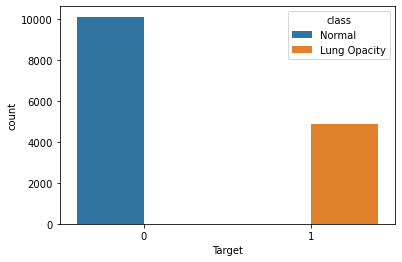

In [ ]:
sns.countplot(x = 'Target', hue = 'class', data = train_mergedata)

<AxesSubplot:xlabel='Target', ylabel='count'>

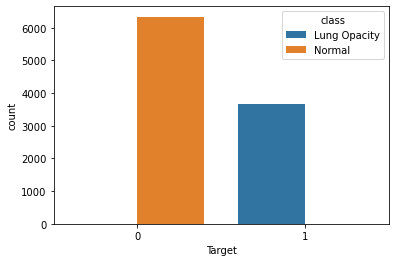

In [ ]:
sns.countplot(x = 'Target', hue = 'class', data = validate_mergedata)

<AxesSubplot:xlabel='Target', ylabel='count'>

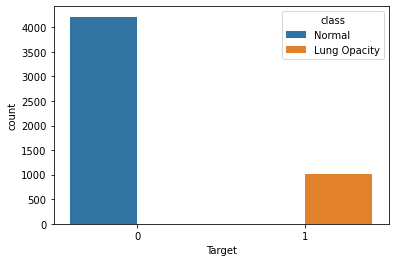

In [ ]:
sns.countplot(x = 'Target', hue = 'class', data = test_mergedata)

## Functions and Class Definitions

Here we will define some of the functions that will help us in creating a model.

* **Loss and Metric Functions**

We will be using **"Jaccard Loss Function"** as the loss function and **"Mean IOU"** to measure the efficiency of the model.

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    """
    Arguments:
        y_true -- ground truth mask 
        y_pred -- predicted mask
    """
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# mean iou as a metric
def mean_iou(y_true, y_pred):
    """
    Arguments:
        y_true -- ground truth mask
        y_pred -- predicted mask
    """
    
    y_pred = tf.round(y_pred)    
    intersect = tf.reduce_sum(y_true * y_pred, axis = [1]) 
    union = tf.reduce_sum(y_true, axis = [1]) + tf.reduce_sum(y_pred, axis = [1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

* Function to obtain Intersection Over Union (IoU) ratio from Ground Truth and Predicted Box Coordinates

In [ ]:
def iouFromCoords(boxA, boxB) :
    """
    Arguments:
        boxA -- ground truth mask
        boxB -- predicted mask
    """
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    intersectionArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if intersectionArea == 0:
        return 0
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union
    iou = intersectionArea / float(boxAArea + boxBArea - intersectionArea)

    # return the intersection over union value
    return iou

* Function to display the image with an imposing mask

In [ ]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    """
    Arguments:
        _imageSet -- set of images 
        _maskSet -- set of masks
        _index -- index of a set/collection
    """
    
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)

* Some basic variables are defined which will be used

In [ ]:
image_size = 224
img_width = 1024
img_height = 1024

train_batch_size = 10
test_batch_size = 10

* A class is being defined to get data batch for training the model

In [ ]:
#Generator class to get data batch for training the model. It extends the Sequence class
class UNetTrainGenerator(Sequence):
    """
    Arguments:
        _imgaeIdpaths: dataframe having patientIds and image paths to load the image
        _mergedata: dataframe having patientId, bounding box coordinates, target and class
        idx: index of the batch
    """
    
    def __init__(self, _imageIdPaths, _mergedata):
        self.pids = _mergedata['patientId'].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * image_size / img_width
        
    def __len__(self):
        return math.ceil(len(self.coords) / train_batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * train_batch_size:(idx + 1) * train_batch_size] #image coords
        batch_pids = self.pids[idx * train_batch_size:(idx + 1) * train_batch_size] #image pids
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype = np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]['imgPath'].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array
            
            resized_image = cv2.resize(img, (image_size, image_size), interpolation = cv2.INTER_AREA)
            
            #preprocess image
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2]) 
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+height] = 1
        
        return batch_images, batch_masks

This class **UNetTrainGenerator** will help to load the training and validation data into the memory.

* A class is being defined to get data batch for testing

In [ ]:
#Generator to Predict the model
class UNetTestGenerator(Sequence):
    """        
    Arguments:
        _imageIdPaths: dataframe having patientId and image paths to load image
        _mergedata: dataframe having patientId, bounding box coordinates, target and class      
        idx -- index of a batch
    """
    
    def __init__(self, _imageIdPaths, _mergedata):       
        self.pids = _mergedata["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[["x", "y", "width", "height", "Target"]].to_numpy()
        self.classes = _mergedata["class"]
        # Resize Bounding box
        self.coordsOrig = self.coords
        self.coords = self.coords * image_size / img_width           

    def __len__(self):
        # Returns total number of batches
        return math.ceil(len(self.coords) / test_batch_size)
    

    def __getitem__(self, idx):
        batch_coords = self.coords[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_coordsOrig = self.coordsOrig[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_pids = self.pids[idx * test_batch_size:(idx + 1) * test_batch_size]    
        batch_classes = self.classes[idx * test_batch_size:(idx + 1) * test_batch_size]           
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            target = int(batch_coords[_indx, 4])
            
            batch_coords[_indx, 0] = x
            batch_coords[_indx, 1] = y 
            batch_coords[_indx, 2] = width 
            batch_coords[_indx, 3] = height    
            batch_coords[_indx, 4] = target 
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        # Returns images, ground truth masks, patientIds, resized-coordinates, class targets and ground truth coordinates/lables.   
        return batch_images, batch_masks, batch_pids, batch_coords, batch_classes, batch_coordsOrig

The above defined class **UNetTestGenerator** will help to load the test data.

## Creating functions for Model Architecture

* ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D,Conv2D,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

model=ResNet50()
def ResNet_model():
  model = Sequential()
  model = ResNet50()
  for layer in model.layers[:-10]:
      layer.trainable = True


  block1 = model.get_layer("conv1_relu").output
  block2 = model.get_layer("conv2_block3_out").output
  block3 = model.get_layer("conv3_block4_out").output
  block4 = model.get_layer("conv4_block6_out").output
  block5 = model.get_layer("conv5_block3_out").output
  
  
  x = Concatenate()([UpSampling2D()(block5), block4])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = Concatenate()([UpSampling2D()(x), block3])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = Concatenate()([UpSampling2D()(x), block2])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = Concatenate()([UpSampling2D()(x), block1])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = UpSampling2D()(x)
  x = Conv2D(1, kernel_size=1,strides=1, activation="sigmoid")(x)
  x = Reshape((224, 224,1))(x)

  return Model(inputs=model.input, outputs=x)

102973440/102967424 [==============================] - 2s 0us/step


* UNet with MobileNet

It is based on the one on which we made our previous submission.

In [ ]:
#Function to create UNet architecture with MobileNet
def create_UNetModel(trainable=True):
    """        
    Arguments:
        trainable: Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape = (image_size, image_size, 3), include_top=False,
                      alpha = 1.0, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)
    # Steps to upsample from 7x7 to 14x14..upto 224x224 to form UNET
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((image_size, image_size))(x) 

    return Model(inputs=model.input, outputs=x)

* UNet with ResNet50

In [ ]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    """       
    Arguments:
        prevlayer: previous layer of the convolution block
        
        filters: number of filters for convolution
        
        prefix: prefix for the layer name
        
        strides: convolution stride. Default is 1x1.
    """
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    
    # Returns the built layers of the block.
    return conv

In [ ]:
def create_ResNetUNetModel(trainable=True):
    """        
    Arguments:
        trainable: Flag to make layers trainable. Default value is 'True'.
    """
    resnetLayers = ResNet50(weights='imagenet', input_shape=(image_size, image_size, 3),
                            include_top=False) # Load pre-trained Resnet

    for layer in resnetLayers.layers:
        layer.trainable = trainable

    # Add all the UNet layers here
    convLayer_112by112 = resnetLayers.get_layer("conv1_relu").output
    convLayer_56by56 = resnetLayers.get_layer("conv2_block3_out").output
    convLayer_28by28 = resnetLayers.get_layer("conv3_block4_out").output
    convLayer_14by14 = resnetLayers.get_layer("conv4_block6_out").output
    convLayer_7by7 = resnetLayers.get_layer("conv5_block3_out").output
    # The last layer of resnet model(conv5_block3_out) is of dimensions (7x7x2048)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNet
    up14by14 = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    upConvLayer_14by14 = conv_block_simple(up14by14, 256, "upConvLayer_14by14_1")
    upConvLayer_14by14 = conv_block_simple(upConvLayer_14by14, 256, "upConvLayer_14by14_2")
    
    up28by28 = Concatenate()([UpSampling2D()(upConvLayer_14by14), convLayer_28by28])
    upConvLayer_28by28 = conv_block_simple(up28by28, 256, "upConvLayer_28by28_1")
    upConvLayer_28by28 = conv_block_simple(upConvLayer_28by28, 256, "upConvLayer_28by28_2")
     
    up56by56 = Concatenate()([UpSampling2D()(upConvLayer_28by28), convLayer_56by56])
    upConvLayer_56by56 = conv_block_simple(up56by56, 256, "upConvLayer_56by56_1")
    upConvLayer_56by56 = conv_block_simple(upConvLayer_56by56, 256, "upConvLayer_56by56_2")    
    
    up112by112 = Concatenate()([UpSampling2D()(upConvLayer_56by56), convLayer_112by112])
    upConvLayer_112by112 = conv_block_simple(up112by112, 256, "upConvLayer_112by112_1")
    upConvLayer_112by112 = conv_block_simple(upConvLayer_112by112, 256, "upConvLayer_112by112_2")   
    
    up224by224 = UpSampling2D(name="unet_last")(upConvLayer_112by112) # upsample to 224x224
    upConvLayer_224by224 = conv_block_simple(up224by224, 256, "upConvLayer_224by224_1")
    upConvLayer_224by224 = conv_block_simple(upConvLayer_224by224, 256, "upConvLayer_224by224_2")   

    # Add classification layer
    upConvLayer_224by224 = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(upConvLayer_224by224)
    upConvLayer_224by224 = Reshape((image_size, image_size))(upConvLayer_224by224) 

    return Model(inputs=resnetLayers.input, outputs=upConvLayer_224by224)

## Some more necessary functions

* Function to create Confusion Matrix and Classification Report

In [ ]:
def showConfusionMatrix(IOU_report) :
    """   
    Arguments:
        IOU_report: dataframe having target and prediction columns.
    """
    
    IOU_report.fillna(0, inplace=True)
    
    # Get Targets and Predictions
    y_IOU_test = IOU_report["Target"]
    y_IOU_predicted = IOU_report["predTarget"]
    print("Predictions in terms of IOU :\n")
    print("Confusion Matrix:\n", metrics.confusion_matrix(y_IOU_test, y_IOU_predicted))
    print("\nClassification Report:\n", metrics.classification_report(y_IOU_test, y_IOU_predicted))

* Function to predict test data set and save the submission report into a csv file

In [ ]:
def predictBatches(_test_mergedata, _test_imageIdpaths, _UNetModel) :
    """        
    Arguments:
        _test_mergedata: test set dataframe having patientId, bounding box coordinates, target and class
        _test_imageIdpaths: test set dataframe having patientId and image paths to load image        
        _UNetModel: UNet model with trainined weights used for predicting test data
    """
    
    print('Number of Test Samples:', _test_mergedata["patientId"].nunique())
    
    # create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdpaths, _test_mergedata)
    
    # create submission dafa frame with column names
    submissionDF = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'x_pred', 'y_pred', 'width_pred', 
                                         'height_pred', 'predTarget', 'iou', 'class_pred'])
    dfIndex = 0
    iouThreshold = 0.3 # IoU above 30%

    # loop through testset
    # for batches from testUNetDataGen
    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:
        
        # predict batch of images
        batchPreds = _UNetModel.predict(batchImages)

        prevPid = ""
        # loop through batch
        for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig):   #for (224, 224)

            if prevPid != pid :
                prevPid = pid

                # resize predicted mask
                pred = resize(pred, (1024, 1024), mode='reflect')   #for (1024, 1024)
                # recompute coords for resized pred
                coords = coordsOrig   #for (1024, 1024)

                # threshold predicted mask
                strongPred = pred[:, :] > 0.5   

                # apply connected components
                strongPred = measure.label(strongPred)

                loopIndx = 0
                # collect all reagions for the prediction
                iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                for region in measure.regionprops(strongPred) :
                    # retrieve x, y, height and width
                    y, x, y2, x2 = region.bbox
                    height = y2 - y
                    width = x2 - x
                    # Get IOUs
                    coordsXYs = np.array([coords[0], coords[1], coords[2]+coords[0], coords[3]+coords[1]])
                    regionXYs = np.array([x, y, x2, y2])
                    IOU = iouFromCoords(coordsXYs, regionXYs)
                    iouCoordsRow = [IOU, x, y, width, height]
                    iouCoordsDF.loc[loopIndx] = iouCoordsRow
                    loopIndx = loopIndx + 1

                GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass] # ground truth data 
                prevGTDFRow = []
                # Get top 2 predictions based on IOU 
                iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                predIOUCoordCount = 0
                # If predictions exist
                if len(iouCoordsDF) > 0 :
                    for predIOUCoordIdx in (0, len(iouCoordsDF)-1) :
                        if iouCoordsDF.loc[predIOUCoordIdx]["iou"] > iouThreshold :
                            # add row with ground truth and prediction values to data frame    
                            submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4],
                                               gtClass, int(iouCoordsDF.loc[predIOUCoordIdx]["x"]), int(iouCoordsDF.loc[predIOUCoordIdx]["y"]), 
                                               int(iouCoordsDF.loc[predIOUCoordIdx]["width"]), int(iouCoordsDF.loc[predIOUCoordIdx]["height"]), 
                                               1, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Lung Opacity"]
                            if predIOUCoordCount < 2 :
                                if GTDFRow != prevGTDFRow : 
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex = dfIndex + 1 
                                    predIOUCoordCount = predIOUCoordCount + 1
                                    prevGTDFRow = GTDFRow
                            else :
                                break;
                        else : # Normal if IOU below threshold
                            # add row with ground truth and prediction values to data frame
                            if GTDFRow != prevGTDFRow :  
                                submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                                   gtClass, 0, 0, 0, 0, 0, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Normal"]
                                submissionDF.loc[dfIndex] = submissionDFRow
                                dfIndex = dfIndex + 1  
                                prevGTDFRow = GTDFRow
                                break;
                else : # else of If predictions exist. Normal if no predictions
                    # add row with ground truth and prediction values to data frame
                    submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                       gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"]
                    submissionDF.loc[dfIndex] = submissionDFRow
                    dfIndex = dfIndex + 1      

    # save dictionary as csv file
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)

* Function to visualize predictions by displaying the ground truth and predicted bounding box

In [ ]:
def visualizePredictions(_predReportDF, _topNum) :
    """        
    Arguments:
        _predReportDF: dataframe having patientId, IoUs, target and prediction coordinate columns.
        _topNum -- number indicating the count of top predictions to be visualized.
    """
    # Sort on IOU to get higher IOUs on top
    _predReportDF.sort_values("iou", ascending=False, inplace=True)
    # Get patientIds
    topPids = _predReportDF["patientId"].head(_topNum)
    topPidsAry = np.array(topPids)
    # Get IOUs
    topIOUs = _predReportDF["iou"].head(_topNum)
    topIOUsAry = np.array(topIOUs)

    # To get ground truth images for top IOU scored pids
    imageCollc = np.zeros((_topNum, img_width, img_height), np.float32)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    gtCoordCollc = _predReportDF[["x", "y", "width", "height"]].to_numpy()
    # To get ground truth masks
    gtMaskCollc  = np.zeros((_topNum, img_width, img_height), np.int)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    predCoordCollc = _predReportDF[["x_pred", "y_pred", "width_pred", "height_pred"]].to_numpy()  # (1024, 1024)
    # To get ground truth masks
    predMaskCollc  = np.zeros((_topNum, img_width, img_height), np.int)

    # Get ground truth and prediction masks
    for indx in range(0, _topNum) :
        # Get images
        path = test_imageIdpaths[test_imageIdpaths["patientId"] == topPidsAry[indx]]["imgPath"].array[0]
        imgData = loadImage(str(path)) # Read image
        img = imgData.pixel_array
        imageCollc[indx][:,:] = preprocess_input(np.array(img[:,:], dtype=np.float32)) # Convert to float32 array

        # prepare ground truth masks
        x = int(gtCoordCollc[indx, 0])
        y = int(gtCoordCollc[indx, 1])
        width = int(gtCoordCollc[indx, 2])
        height = int(gtCoordCollc[indx, 3])
        gtMaskCollc[indx][y:y+height, x:x+width] = 1   # (1024, 1024)

        # prepare predicted masks
        x_pred = int(predCoordCollc[indx, 0])
        y_pred = int(predCoordCollc[indx, 1])
        width_pred = int(predCoordCollc[indx, 2])
        height_pred = int(predCoordCollc[indx, 3])
        predMaskCollc[indx][y_pred:y_pred+height_pred, x_pred:x_pred+width_pred] = 1   # (1024, 1024)
        
    # Show images and bounding boxes
    imageArea, axesArry = pyplot.subplots(int(_topNum/2), 2, figsize=(18,18))
    axesArry = axesArry.ravel()
    for axidx in range(0, _topNum) :
        axesArry[axidx].imshow(imageCollc[axidx][:, :], cmap=pyplot.cm.bone)

        gtComp = gtMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        gtComp = measure.label(gtComp)
        # apply ground truth bounding boxes
        for region in measure.regionprops(gtComp):
            # retrieve x, y, height and width
            y1, x1, y2, x2 = region.bbox
            heightReg = y2 - y1
            widthReg = x2 - x1
            axesArry[axidx].add_patch(patches.Rectangle((x1, y1), widthReg, heightReg, linewidth=1, edgecolor='r', 
                                                        facecolor='none'))

        predComp = predMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        predComp = measure.label(predComp)
        # apply predicted bounding boxes
        for region_pred in measure.regionprops(predComp):
            # retrieve x, y, height and width
            y1_pred, x1_pred, y2_pred, x2_pred = region_pred.bbox
            heightReg_pred = y2_pred - y1_pred
            widthReg_pred = x2_pred - x1_pred
            axesArry[axidx].add_patch(patches.Rectangle((x1_pred, y1_pred), widthReg_pred, heightReg_pred, linewidth=1, edgecolor='b', 
                                                        facecolor='none'))
            axesArry[axidx].set_title('IOU : '+str(topIOUsAry[axidx]))
    # Show subplots
    pyplot.show()

#### Create Generator instances for Train and Validation datasets

In [ ]:
trainUNet = UNetTrainGenerator(train_imageIdpaths, train_mergedata)
validateUNet = UNetTrainGenerator(validate_imageIdpaths, validate_mergedata)

## Training model

#### ResNet50

In [ ]:
model=ResNet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

The above model will have a total of 24,008, 613 params. Out of which we have 23,955,493 params as trainable params

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

checkpoint_or = ModelCheckpoint("onlyres-{epoch:02d}-{val_mean_iou:.2f}.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)

model.compile(optimizer = adamopt_r, loss = iou_loss, metrics = [mean_iou])

history_ures = model.fit_generator(generator = trainUNet, epochs = 10,
                                   validation_data = validateUNet,
                                   callbacks = [learning_rate, checkpoint_or, stop],
                                   shuffle = True, verbose = 1)

Epoch 1/10
1500/1500 [==============================] - 384s 253ms/step - loss: 0.8734 - mean_iou: 0.9058 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00001: loss improved from inf to 0.87785, saving model to onlyres-01-0.88.h5
Epoch 2/10
1500/1500 [==============================] - 378s 252ms/step - loss: 0.8716 - mean_iou: 0.9063 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00002: loss did not improve from 0.87785
Epoch 3/10
1500/1500 [==============================] - 382s 255ms/step - loss: 0.8829 - mean_iou: 0.9064 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00003: loss did not improve from 0.87785
Epoch 4/10
1500/1500 [==============================] - 376s 251ms/step - loss: 0.8623 - mean_iou: 0.9078 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00004: loss did not improve from 0.87785


As, the loss didn't improved from 0.87785 for three consecutive epochs, so it stopped training. We will be using the weights from the best available models "onlyres-01-0.88.h5" to see how our model worked on the test set. 

In [ ]:
model.load_weights('./onlyres-01-0.88.h5')

In [ ]:
y_test, y_predicted = predictBatches(test_mergedata, test_imageIdpaths, model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!


In [ ]:
report_file_res = pd.read_csv('./submission.csv')
showConfusionMatrix(report_file_res)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 740    0]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      4214
         1.0       0.00      0.00      0.00       740

    accuracy                           0.85      4954
   macro avg       0.43      0.50      0.46      4954
weighted avg       0.72      0.85      0.78      4954



Analysis from the Confusion Matrix:
* True Positives(TP) - 0 cases which is a point of concern. Thus, our model failed in successfully predicting the cases of Pneumonia pr cases with Lung Opacity
* True Negatives(TN) - 4214 patients who have actually 'No Lung Opacity'/'Normal' are correctly predicted as 'Normal' or cases with no Pneumonia
* False Positives(FP) - 0 cases who have actually 'No Lung Opacity'/'Normal' incorrectly predicted as having 'Lung Opacity'. This means there are no model mistakes in identifying 'Normal' as 'Lung Opacity'. Type-I error is zero. This is a big positive point for a medical test
* False Negatives(FN) are - 740 cases where the patients who have actually 'Lung Opacity' or 'Pneumonia' are incorrectly predicted as'Normal'. These are model mistakes.

Thus, we need to seek some other architecture.

#### UNet with MobileNet

In [ ]:
UNet_MobileNet_Model = create_UNetModel()
print(UNet_MobileNet_Model.summary())

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

Thus, UNet with MobileNet has a total of 3,230,849 parameters. Out of which 3,208,961 parameters are trainable and the rest are non-trainable. 

Using Adam optimizer and Compliling the model

In [ ]:
#optimizer
adamopt = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
UNet_MobileNet_Model.compile(optimizer = adamopt, loss = iou_loss, metrics = [mean_iou])

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("umobile-{epoch:02d}-{val_mean_iou:.2f}.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [ ]:
history_umobile = UNet_MobileNet_Model.fit_generator(generator = trainUNet, epochs = 5,
                                                    validation_data = validateUNet,
                                                    callbacks = [learning_rate, checkpoint, stop],
                                                    shuffle = True, verbose = 1)

Epoch 1/5
1500/1500 [==============================] - 626s 414ms/step - loss: 0.8448 - mean_iou: 0.7392 - val_loss: 0.7483 - val_mean_iou: 0.7677

Epoch 00001: loss improved from inf to 0.82750, saving model to umobile-01-0.77.h5
Epoch 2/5
1500/1500 [==============================] - 561s 374ms/step - loss: 0.8096 - mean_iou: 0.8036 - val_loss: 0.7591 - val_mean_iou: 0.7565

Epoch 00002: loss improved from 0.82750 to 0.80436, saving model to umobile-02-0.76.h5
Epoch 3/5
1500/1500 [==============================] - 559s 372ms/step - loss: 0.7921 - mean_iou: 0.7992 - val_loss: 0.7409 - val_mean_iou: 0.8286

Epoch 00003: loss improved from 0.80436 to 0.79297, saving model to umobile-03-0.83.h5
Epoch 4/5
1500/1500 [==============================] - 559s 372ms/step - loss: 0.7805 - mean_iou: 0.8215 - val_loss: 0.7409 - val_mean_iou: 0.8366

Epoch 00004: loss improved from 0.79297 to 0.78715, saving model to umobile-04-0.84.h5
Epoch 5/5
1500/1500 [==============================] - 561s 374m

So, after 5 epochs we had come to a loss of 0.7781 on training set and 0.7494 on validation set. Similarly, we have achieved a Mean IOU of 0.8193 on training set and 0.8482 on validation set. As the two values are quite close, so there isn't a case of overfitting as was observed in previous submission.

Going forward, we will be using the weights from "umobile-05-0.85". 

In [ ]:
UNet_MobileNet_Model.load_weights('./umobile-05-0.85.h5')

Predicting on the test set

In [ ]:
y_test, y_predicted = predictBatches(test_mergedata, test_imageIdpaths, UNet_MobileNet_Model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!


In [ ]:
report_file_um = pd.read_csv('./submission.csv')
showConfusionMatrix(report_file_um)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 599  141]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      4214
         1.0       1.00      0.19      0.32       740

    accuracy                           0.88      4954
   macro avg       0.94      0.60      0.63      4954
weighted avg       0.89      0.88      0.84      4954



**Analysis of Confusion Matrix**:
* True Positives(TP) -  Out of 740 actual cases of "Lung Opacity" or "Pneumonia" for 141 patients our model has been able to successfuly predict it
* True Negatives(TN) - All the non-cases of 'No Lung Opacity'/'Normal' or patients not having Pneumonia has been predicted correctly by our model
* False Positives(FP) - There hasn't been any cases where our model predicted patients who have actually 'No Lung Opacity'/'Normal' (i.e., Patients without Pneumonia) as patients having 'Lung Opacity' or suffering from Pneumonia
* False Negatives(FN) - For 599 patients who have actually 'Lung Opacity' our patient predicted them as 'Normal' or No Pneumonia.

**Analysis of Classification Report**:
Our model has an accuracy of 88%.

Visualization of our Prediction

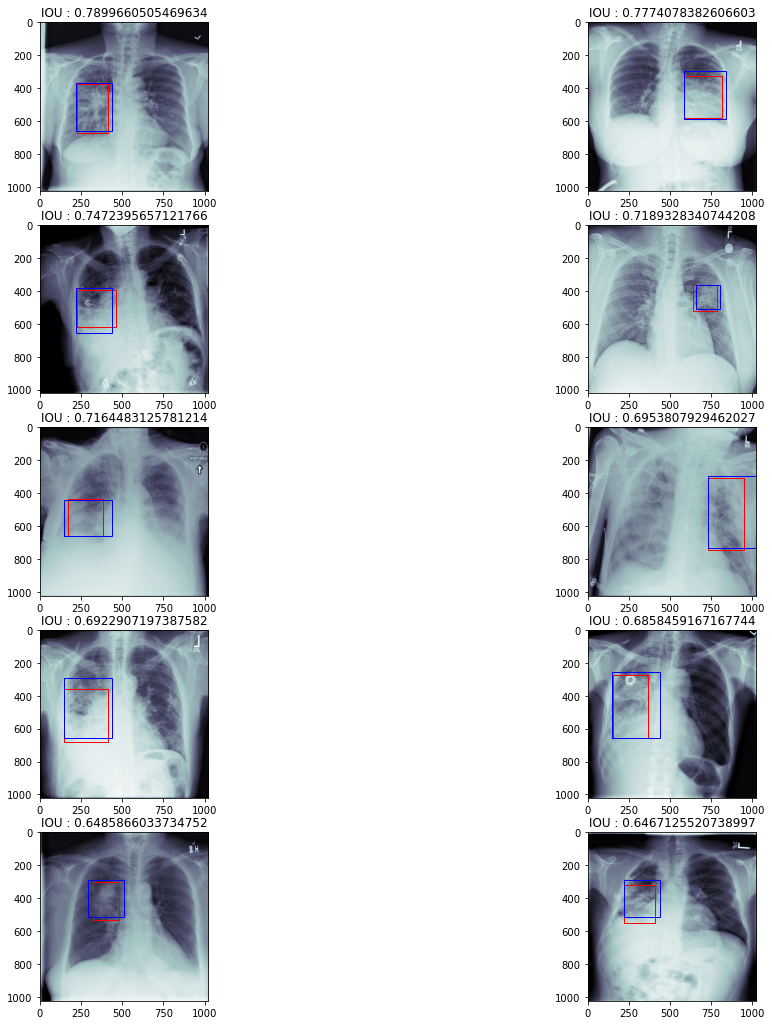

In [ ]:
top = 10
visualizePredictions(report_file_um, top)

Though not exactly but our model has been able to locate the region of opacities in the chest.

#### Function to plot the performance curves

In [ ]:
def plotHistory(_HISTORY_FILE) :
    """        
    Arguments:
        _HISTORY_FILE: training history file name.
    """
    unetSavedHistory = np.load(_HISTORY_FILE, allow_pickle=True).item()
    unetSavedHistoryDF = pd.DataFrame(unetSavedHistory)
    
    #summarize history for loss
    pyplot.plot(unetSavedHistoryDF['loss'])
    pyplot.plot(unetSavedHistoryDF['val_loss'])
    pyplot.title('Model Loss')
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validation'], loc='best')
    pyplot.show()
    
    # summarize history for mean IOU
    pyplot.plot(unetSavedHistoryDF['mean_iou'])
    pyplot.plot(unetSavedHistoryDF['val_mean_iou'])
    pyplot.title('Model IOU')
    pyplot.ylabel('IOU')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validation'], loc='best')
    pyplot.show()

In [ ]:
umobhist = np.array(history_umobile.history)
np.save("History_UNM", umobhist, allow_pickle = True)

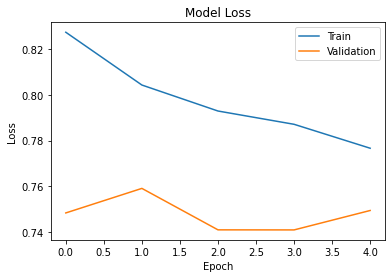

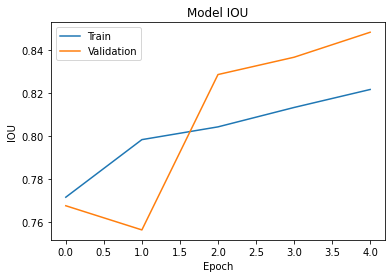

In [ ]:
history_file = './History_UNM.npy'
plotHistory(history_file)

From the above two curves it is clear that with passage of time (i.e., epochs) our model has performed better. The tendency to overfit gets reduced with each epoch.

### UNet with ResNet50

In [ ]:
UNet_ResNet_Model = create_ResNetUNetModel()
print(UNet_ResNet_Model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

Thus, UNet with ResNet50 (with some more additional layers) has a total of 37,904,001 parameters. Out of which 37,845,761 parameters are trainable and the rest are non-trainable.

Using Adam Optimizer and compiling the model

In [ ]:
#optimizer
adamopt_r = Adam(lr = 1e-1, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
UNet_ResNet_Model.compile(optimizer = adamopt_r, loss = iou_loss, metrics = [mean_iou])

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("ures-{epoch:02d}-{val_mean_iou:.2f}.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [ ]:
history_unres = UNet_ResNet_Model.fit_generator(generator = trainUNet, epochs = 5,
                                               validation_data = validateUNet,
                                               callbacks = [learning_rate, checkpoint, stop],
                                               shuffle = True, verbose = 1)

Epoch 1/5
1500/1500 [==============================] - 882s 583ms/step - loss: 0.8692 - mean_iou: 0.7098 - val_loss: 0.8626 - val_mean_iou: 0.4900

Epoch 00001: loss improved from inf to 0.85659, saving model to ures-01-0.49.h5
Epoch 2/5
1500/1500 [==============================] - 871s 581ms/step - loss: 0.8415 - mean_iou: 0.7720 - val_loss: 0.8692 - val_mean_iou: 0.8339

Epoch 00002: loss improved from 0.85659 to 0.83422, saving model to ures-02-0.83.h5
Epoch 3/5
1500/1500 [==============================] - 872s 581ms/step - loss: 0.8162 - mean_iou: 0.7803 - val_loss: 0.8164 - val_mean_iou: 0.6031

Epoch 00003: loss improved from 0.83422 to 0.81938, saving model to ures-03-0.60.h5
Epoch 4/5
1500/1500 [==============================] - 876s 584ms/step - loss: 0.8144 - mean_iou: 0.7813 - val_loss: 0.7775 - val_mean_iou: 0.7661

Epoch 00004: loss improved from 0.81938 to 0.81518, saving model to ures-04-0.77.h5
Epoch 5/5
1500/1500 [==============================] - 877s 584ms/step - los

So, after 5 epochs we had come to a loss of 0.8073 on training set and 0.8186 on validation set. As the two values are quite close, so there isn't a case of overfitting as was observed in previous submission.

Going forward, we will be using the weights from "ures-05-0.85.h5".

In [ ]:
UNet_ResNet_Model.load_weights('./ures-05-0.85.h5')

Predicting on the test set

In [ ]:
y_test, y_predicted = predictBatches(test_mergedata, test_imageIdpaths, UNet_ResNet_Model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!


In [ ]:
report_file_ur = pd.read_csv('./submission.csv')
showConfusionMatrix(report_file_ur)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 597  143]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      4214
         1.0       1.00      0.19      0.32       740

    accuracy                           0.88      4954
   macro avg       0.94      0.60      0.63      4954
weighted avg       0.89      0.88      0.84      4954



**Analysis of Confusion Matrix**:
* True Positives(TP) - Out of 740 actual cases of "Lung Opacity" or "Pneumonia" for 143 patients our model has been able to successfuly predict it
* True Negatives(TN) - All the non-cases of 'No Lung Opacity'/'Normal' or patients not having Pneumonia has been predicted correctly by our model
* False Positives(FP) - There hasn't been any cases where our model predicted patients who have actually 'No Lung * Opacity'/'Normal' (i.e., Patients without Pneumonia) as patients having 'Lung Opacity' or suffering from Pneumonia
* False Negatives(FN) - For 597 patients who have actually 'Lung Opacity' our patient predicted them as 'Normal' or No Pneumonia.
**Analysis of Classification Report**: 
Our model has an accuracy of 88% which is same as that of the UNet with MobileNet.

Visualizing the Prediction

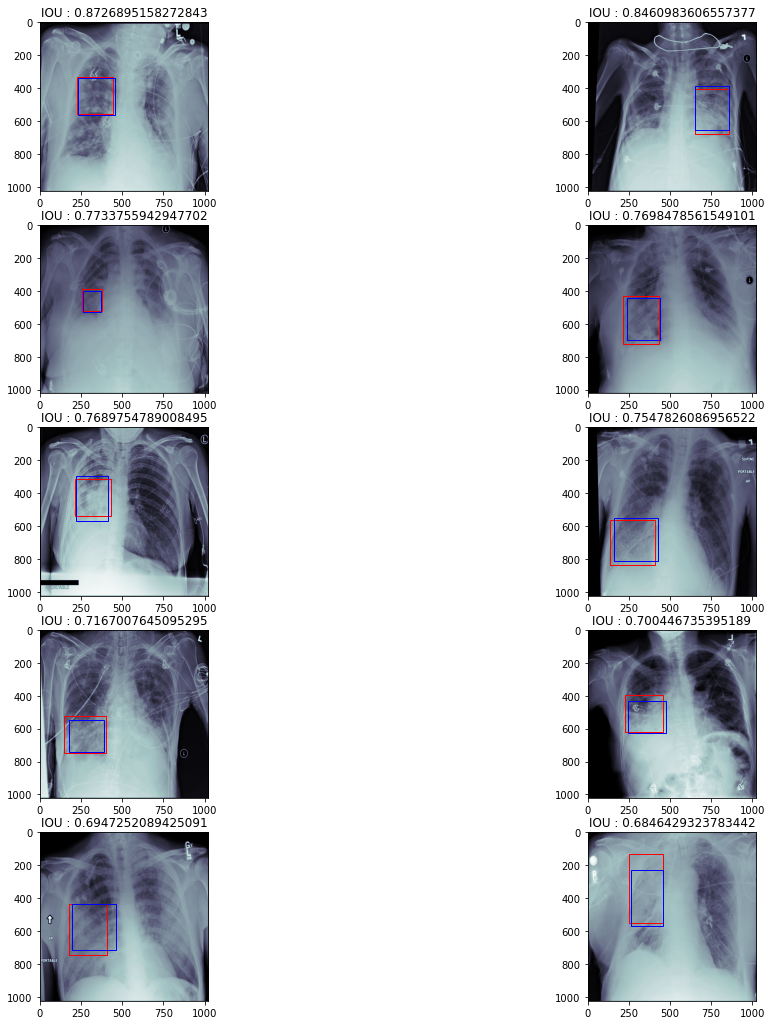

In [ ]:
top = 10
visualizePredictions(report_file_ur, top)

Though not exactly but our model has been able to locate the region of opacities in the chest.

In [ ]:
ureshist = np.array(history_unres.history)
np.save("History_UR", ureshist, allow_pickle = True)

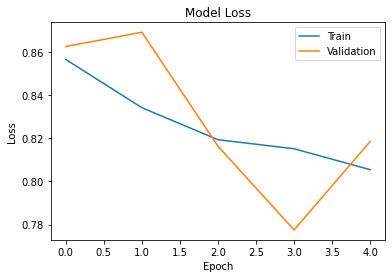

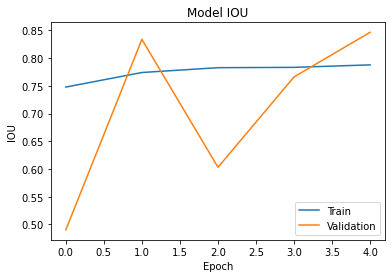

In [ ]:
history_file = './History_UR.npy'
plotHistory(history_file)

From the above two curves it is clear that with passage of time (i.e., epochs) our model has performed better. The tendency to overfit gets reduced with each epoch.

## Summary

* Our project started with exploring the given dataset and find how the various attributes (obtained from both the files and images) are spread across the entire dataset
* After making the interim submission where we proposed a solution using MobileNet and Transfer Learning (using UNet) there were two challenges for us: First to write a function that can load the entire dataset at once and secondly Model Selection. Model selection was a challenge as both localization and classification were needed to clubbed into one. We tried to develop a model on just ResNet, MobileNet, VGG19 and DenseNet
* After working on different models we realized that U-Net with binary classification works better for us. Moreover, we found that U-Net is also widely used in medical applications. Hence switched to U-Net
* This time we tried with three different architectures involving UNet: One with MobileNet and two different variants of ResNet50 
* After training all the three variants we sticked with UNet and ResNet50 (the third one). With this model we were successfully able to predict Pneumonia in 145 patients. Overall accuracy was 88%.